# LAB 4: Analyzing Network Data Log
You are provided with the data file, in .csv format, in the working directory.  Write the program to extract the following informations. 

In [1]:
import pandas as pd
import ipinfo
import json
import igraph as ig
import math

In [2]:
access_token = ''
handler = ipinfo.getHandler(access_token)

## Read Data, Cleaning, and Checking

Column Names taken from Traffic Log Data (section 5.2 of lab manual), see SFlow traffic data.

In [3]:
# ignore "ParseWarning: length of header or names does not match length of data"
# because the csv file has an extra empty column
df = pd.read_csv('lab4_sampledata.csv', index_col=False,
                 names=['Type', 'sflow_agent_addr', 'inputPort', 'outputPort',
                       'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
                       'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
                        'src_port_addr', 'dst_port_addr', 'tcp_flags', 'packet_size',
                        'IP_size', 'sampling_rate'])
df.sample(5)

C:\Users\HERHUE~1\AppData\Local\Temp/ipykernel_17136/238929878.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('lab4_sampledata.csv', index_col=False,


,Type,sflow_agent_addr,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_port_addr,dst_port_addr,tcp_flags,packet_size,IP_size,sampling_rate
32,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,14.139.196.58,192.101.107.153,6,0x00,57,45374.0,43602,0x10,58,40,2048
572,FLOW,aa.aa.aa.aa,137,199,d404ff55fd4d,544b8cf9a7df,0x0800,919.0,600,14.139.5.218,202.179.252.18,17,0x00,251,9598.0,9042,0x10,60,42,2048
936,FLOW,aa.aa.aa.aa,136,19,5c5eabb2b0ce,e00eda07c0ff,0x0800,919.0,102,104.44.201.152,202.21.159.244,6,0x00,123,443.0,24873,0x18,376,358,2048
234,FLOW,aa.aa.aa.aa,21,19,5c5eabb2a7cd,e00eda07c0ff,0x0800,2121.0,102,104.44.201.152,202.21.159.244,6,0x00,124,443.0,18138,0x18,181,163,2048
621,FLOW,aa.aa.aa.aa,258,20,204e71cf1b0f,002438aa0a00,0x0800,3012.0,3012,216.165.102.1,198.71.44.169,50,0x00,242,443.0,57666,0x10,622,600,2048


In [4]:
print(len(df), " rows")

1200  rows


In [5]:
# Check for NaN values
for col in df.columns:
    if df[col].isna().values.any():
        print('NaN values found in column ', col)

In [6]:
# check for unconventional IP addresses
for idx, row in df.iterrows():
    if len(row['src_IP'].split('.')) != 4 or len(row['dst_IP'].split('.')) != 4:
        print('#', idx, sep="")
        print('Source IP:', row['src_IP'], '\tDest IP: ', row['dst_IP'])
        print('Source MAC:', row['src_MAC'], '\tDest MAC: ', row['dst_MAC'])
        print('Packet Size:', row['IP_size'], end="\n\n")
        
# check for IPv6 IP addresses
print('--- IPv6 addresses ---')
for idx, row in df.iterrows():
    if len(row['src_IP'].split('.')) == 8 or len(row['dst_IP'].split('.')) == 8:
        print('#', idx, sep="")
        print('Source IP:', row['src_IP'], '\tDest IP: ', row['dst_IP'])
        print('Source MAC:', row['src_MAC'], '\tDest MAC: ', row['dst_MAC'])
        print('Packet Size:', row['IP_size'], end="\n\n")

#70
Source IP: 0 	Dest IP:  0
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#71
Source IP: 50969 	Dest IP:  2
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#72
Source IP: 20456354 	Dest IP:  1
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#73
Source IP: 2714187 	Dest IP:  6725718
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#74
Source IP: 23236118 	Dest IP:  42834
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#806
Source IP: 179829154 	Dest IP:  60428234
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#807
Source IP: 7391475 	Dest IP:  0
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#808
Source IP: 10854203 	Dest IP:  11
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#809
Source IP: 44541227 	Dest IP:  2546015
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#810
Source IP: 1026942 	Dest IP:  0
Source MAC: 10000000000 	Dest MAC:  1
Packet Size: 0

#811
Source IP: 349682 	Dest IP:  39761
Source MAC: 10000000000 	Dest MAC

In [7]:
# convert to base-256 dotted-decimal IP address
def to_dotted_decimal(decimal):
    d = decimal
    ip = ['0', '0', '0', '0']
    for i in range(3, -1, -1):
        if d < 256:
            ip[i] = str(d)
            break

        q = d // 256
        ip[i] = str(d - q * 256)
        d = q
    
    return '.'.join(ip)

for idx, row in df.iterrows():
    # IPv6 addresses are valid
    if len(row['src_IP'].split('.')) == 4 and len(row['dst_IP'].split('.')) == 4:
        continue
        
    print('#', idx, sep="")
    if len(row['src_IP'].split('.')) != 4:
        print('Old Source IP:', row['src_IP'])
        df.at[idx, 'src_IP'] = to_dotted_decimal(int(row['src_IP']))
        print('New Source IP:', df.at[idx, 'src_IP'])
    if len(row['dst_IP'].split('.')) != 4:
        print('Old Dest IP:', row['dst_IP'])
        df.at[idx, 'dst_IP'] = to_dotted_decimal(int(row['dst_IP']))
        print('New Dest IP:', df.at[idx, 'dst_IP'])
    print()

#70
Old Source IP: 0
New Source IP: 0.0.0.0
Old Dest IP: 0
New Dest IP: 0.0.0.0

#71
Old Source IP: 50969
New Source IP: 0.0.199.25
Old Dest IP: 2
New Dest IP: 0.0.0.2

#72
Old Source IP: 20456354
New Source IP: 1.56.35.162
Old Dest IP: 1
New Dest IP: 0.0.0.1

#73
Old Source IP: 2714187
New Source IP: 0.41.106.75
Old Dest IP: 6725718
New Dest IP: 0.102.160.86

#74
Old Source IP: 23236118
New Source IP: 1.98.142.22
Old Dest IP: 42834
New Dest IP: 0.0.167.82

#806
Old Source IP: 179829154
New Source IP: 10.183.249.162
Old Dest IP: 60428234
New Dest IP: 3.154.15.202

#807
Old Source IP: 7391475
New Source IP: 0.112.200.243
Old Dest IP: 0
New Dest IP: 0.0.0.0

#808
Old Source IP: 10854203
New Source IP: 0.165.159.59
Old Dest IP: 11
New Dest IP: 0.0.0.11

#809
Old Source IP: 44541227
New Source IP: 2.167.165.43
Old Dest IP: 2546015
New Dest IP: 0.38.217.95

#810
Old Source IP: 1026942
New Source IP: 0.15.171.126
Old Dest IP: 0
New Dest IP: 0.0.0.0

#811
Old Source IP: 349682
New Source IP: 

## Exercise 4A: Top Talkers and Listeners

One of the most commonly used functions in analyzing data log is finding out the IP address of the hosts that send out large amounts of packet and hosts that receive a large number of packets, usually known as TOP TALKERS and LISTENERS.

Based on the IP address we can obtain the organization who owns the IP address. 

### TOP 5 TALKERS

In [8]:
top5talkers = df['src_IP'].value_counts()[:5]

print('Talker IP Address  Packets Sent')
print(top5talkers, end='\n\n\n')
for i in range(len(top5talkers)):
    details = handler.getDetails(top5talkers.index[i])
    print('Talker #', i + 1, sep="")
    print('IP Address:', top5talkers.index[i], '\nPackets Sent:', top5talkers.values[i])
    try:
        print('ipinfo Organisation:', details.org)
    except:
        print('-- no ipinfo for org --')
    print()
    
# their organisations
# talkers_addr = top5talkers.index.tolist()
# for talker in talkers_addr:
#     details = handler.getDetails(talker)
#     print(talker, '   ', details.org)

Talker IP Address  Packets Sent
152.3.219.19       126
207.241.228.157     66
130.14.250.13       63
193.62.192.8        46
192.122.131.36      40
Name: src_IP, dtype: int64


Talker #1
IP Address: 152.3.219.19 
Packets Sent: 126
ipinfo Organisation: AS13371 Duke University

Talker #2
IP Address: 207.241.228.157 
Packets Sent: 66
ipinfo Organisation: AS7941 Internet Archive

Talker #3
IP Address: 130.14.250.13 
Packets Sent: 63
ipinfo Organisation: AS70 National Library of Medicine

Talker #4
IP Address: 193.62.192.8 
Packets Sent: 46
ipinfo Organisation: AS786 Jisc Services Limited

Talker #5
IP Address: 192.122.131.36 
Packets Sent: 40
ipinfo Organisation: AS23767 A-STAR



### TOP 5 LISTENERS

In [9]:
top5listeners = df['dst_IP'].value_counts()[:5]

print('Listener IP Addr  Packets Received')
print(top5listeners, end='\n\n\n')
for i in range(len(top5listeners)):
    details = handler.getDetails(top5listeners.index[i])
    print('Listener #', i + 1, sep="")
    print('IP Address:', top5listeners.index[i], '\nPackets Received:', top5listeners.values[i])
    try:
        print('ipinfo Organisation:', details.org)
    except:
        print('-- no ipinfo for org --')
    print()

Listener IP Addr  Packets Received
198.71.44.98      126
103.37.198.100     98
210.48.222.9       66
137.132.228.15     50
202.21.159.244     38
Name: dst_IP, dtype: int64


Listener #1
IP Address: 198.71.44.98 
Packets Received: 126
-- no ipinfo for org --

Listener #2
IP Address: 103.37.198.100 
Packets Received: 98
ipinfo Organisation: AS23767 A-STAR

Listener #3
IP Address: 210.48.222.9 
Packets Received: 66
ipinfo Organisation: AS45344 International Islamic University Of Malaysia

Listener #4
IP Address: 137.132.228.15 
Packets Received: 50
ipinfo Organisation: AS7472 NUS Information Technology

Listener #5
IP Address: 202.21.159.244 
Packets Received: 38
ipinfo Organisation: AS23728 Republic Polytechnic. Multihoming AS Singapore



## Exercise 4B: Transport Protocol

Using the IP protocol type attribute, determine the percentage of TCP and UDP protocol

**After research:**
* 6 - Transmission Control Protocol (TCP)
* 17 - User Datagram Protocol (UDP)

In [10]:
df['IP_protocol'].value_counts()

6      879
50     140
17     135
0       28
47      14
41       2
1        1
381      1
Name: IP_protocol, dtype: int64

In [11]:
protocol_counts = json.loads(df['IP_protocol'].value_counts().to_json())
total = sum(df['IP_protocol'].value_counts())

print('As a Percentage of Total Packets')
print('TCP:', protocol_counts['6'] / total * 100, '%')
print('UDP:', protocol_counts['17'] / total * 100, '%')

As a Percentage of Total Packets
TCP: 73.25 %
UDP: 11.25 %


## Exercise 4C: Applications Protocol

Using the Destination IP port number determine the most frequently used application protocol.
(For finding the service given the port number https://www.adminsub.net/tcp-udp-port-finder/ )

**After research:**
* 443 - HTTPS
* 0 - Reserved
* 56152 - Dynamic and/or Private Ports
* 43930 - Unassigned
* 80 - HTTP

In [12]:
df['dst_port_addr'].value_counts()

443      234
0         82
56152     82
43930     45
80        37
        ... 
25965      1
38643      1
40150      1
50005      1
7223       1
Name: dst_port_addr, Length: 290, dtype: int64

## Exercise 4D: Traffic

The traffic intensity is an important parameter that a network engineer needs to monitor closely to determine if there is congestion. You would use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds. (Assume the sampling rate is 1 in 1000)  

**After research:**
SFlow IP packet size is given in bytes.

In [25]:
sampling_rate = 1 / 1000

# convert to Mega bytes
total_mb = df['IP_size'].sum() / 1000000 / sampling_rate

print('Estimated total traffic in MB =', total_mb)

Estimated total traffic in MB = 1079.8829999999998


## Exercise 4E: Additional Analysis

Please append ONE page to provide additional analysis of the data and the insight it provides.

Examples include:
* Top 5 communication pairs; 
* Visualization of communications between different IP hosts;
* etc.

Please limit your results within one page (and any additional results that fall beyond one page limit will not be assessed).


### Top 5 Communication Pairs

In [14]:
top5cp = df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending=False)[:5]

print('Source IP Addr   Dest IP Addr     Packets')
print(top5cp, end='\n\n\n')
for i in range(len(top5cp)):
    src_details = handler.getDetails(top5cp.index[i][0])
    dst_details = handler.getDetails(top5cp.index[i][1])
    print('Communication Pair #', i + 1, sep="")
    print('Source IP Address:', top5cp.index[i][0], '\nDest IP Address:', top5cp.index[i][1], '\nPackets:', top5cp.values[i])
    try:
        print('Source Org:', src_details.org)
    except:
        print('-- no ipinfo for SOURCE org --')
    try:
        print('Dest Org:', dst_details.org)
    except:
        print('-- no ipinfo for DEST org --')
    print()

Source IP Addr   Dest IP Addr     Packets
src_IP           dst_IP        
152.3.219.19     198.71.44.98      126
207.241.228.157  210.48.222.9       66
130.14.250.13    103.37.198.100     63
193.62.192.8     137.132.228.15     46
137.132.228.15   193.62.192.8       35
dtype: int64


Communication Pair #1
Source IP Address: 152.3.219.19 
Dest IP Address: 198.71.44.98 
Packets: 126
Source Org: AS13371 Duke University
-- no ipinfo for DEST org --

Communication Pair #2
Source IP Address: 207.241.228.157 
Dest IP Address: 210.48.222.9 
Packets: 66
Source Org: AS7941 Internet Archive
Dest Org: AS45344 International Islamic University Of Malaysia

Communication Pair #3
Source IP Address: 130.14.250.13 
Dest IP Address: 103.37.198.100 
Packets: 63
Source Org: AS70 National Library of Medicine
Dest Org: AS23767 A-STAR

Communication Pair #4
Source IP Address: 193.62.192.8 
Dest IP Address: 137.132.228.15 
Packets: 46
Source Org: AS786 Jisc Services Limited
Dest Org: AS7472 NUS Information Tech

### Visualising of Communications between different IP Hosts

In [15]:
df_comms = df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending=False).to_frame('packets').reset_index()
df_comms.sample(5)

,src_IP,dst_IP,packets
164,219.74.37.63,123.136.68.156,1
111,220.156.176.16,130.14.29.35,2
188,40.100.29.194,202.6.241.88,1
135,155.69.253.6,172.217.26.78,1
321,143.215.4.17,137.132.221.90,1


In [16]:
# convert to a list of tuples (1/3 of the tuples only)
# tuples = [tuple(p) for p in df_comms.head(n=len(df_comms//2)).to_numpy()]
tuples = [tuple(p) for p in df_comms.to_numpy()]

# graph
network_graph = ig.Graph.TupleList(tuples, directed = True, weights = True)
network_graph.vs['size'] = 20
network_graph.vs['color'] = 'brown'
network_graph.vs['label'] = network_graph.vs['name']
network_graph.vs['label_size'] = 15

network_graph.es['color'] = 'blue'
network_graph.es['arrow_size'] = 0.7
network_graph.es['width'] = [max(math.log(weight), 0.1) for weight in network_graph.es['weight']]

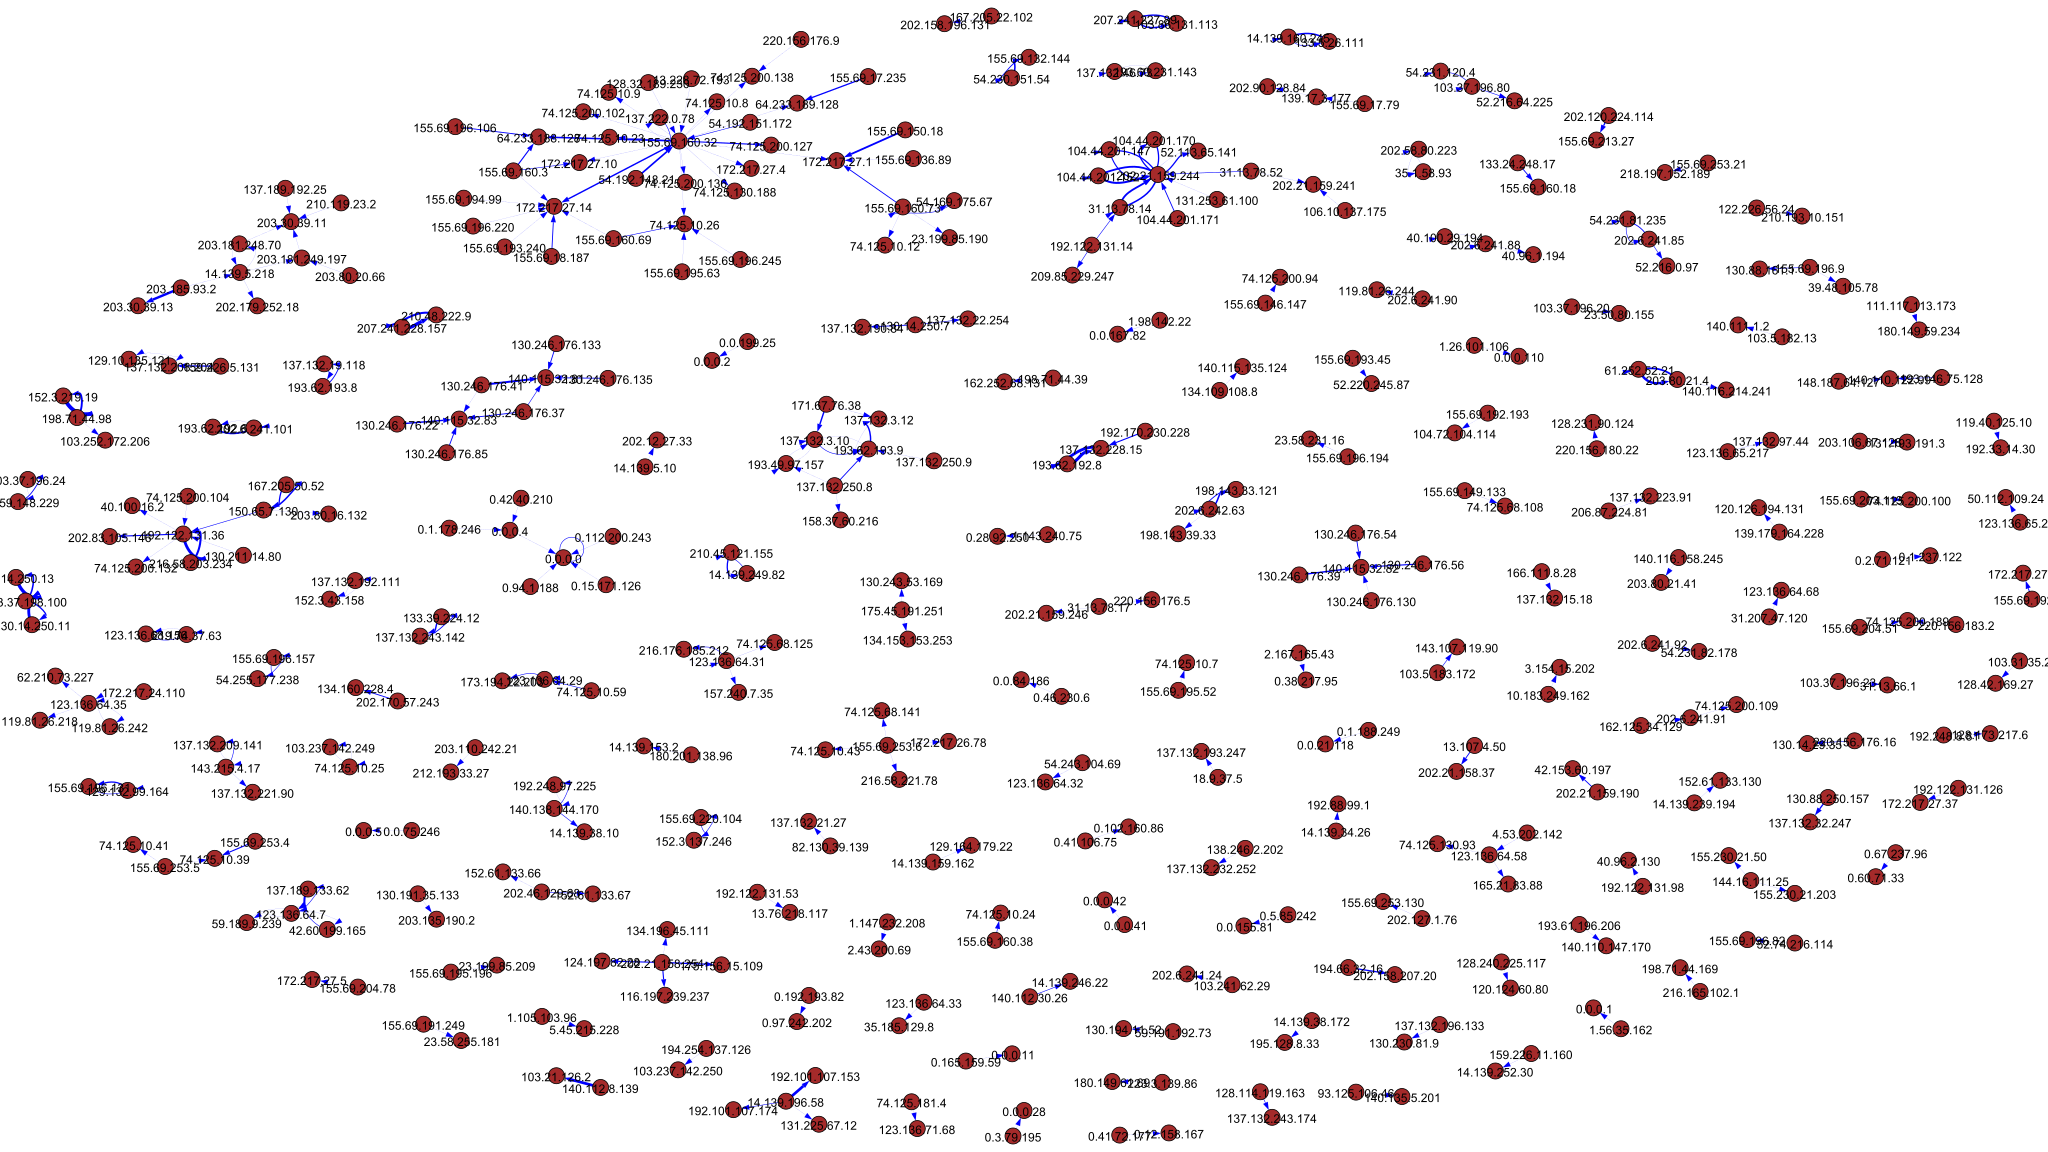

In [17]:
layout = network_graph.layout('fr')
ig.plot(network_graph, layout = layout, bbox = (1024, 768))
ig.plot(network_graph, 'network.png', layout = layout, bbox = (2560, 1440))

### Top inputPort and outputPort

In [18]:
topInputPorts = df['inputPort'].value_counts()[:5]

print('Port  Packets Received')
print(topInputPorts)

Port  Packets Received
258    329
199    171
129    115
137    110
200     90
Name: inputPort, dtype: int64


In [19]:
topOutputPorts = df['outputPort'].value_counts()[:5]

print('Port  Packets Sent')
print(topOutputPorts)

Port  Packets Sent
199    164
193    139
20     127
200    106
130    103
Name: outputPort, dtype: int64


### Most Prevalent Types of...

In [20]:
# Type
df['Type'].value_counts()

FLOW    1171
CNTR      29
Name: Type, dtype: int64

In [21]:
# Ethernet
df['ethernet_type'].value_counts()

0x0800    1171
3           28
0            1
Name: ethernet_type, dtype: int64

In [22]:
# TCP Flag
df['tcp_flags'].value_counts()

0x10         942
0x00         119
0x18          96
0x02          11
303972         2
0x12           2
98626300       1
6465481        1
55688077       1
98287177       1
100886         1
14002593       1
35801365       1
6527408        1
6527200        1
64464331       1
365879         1
303973         1
188072497      1
303961         1
359305         1
811404         1
616157         1
79910026       1
151664721      1
303970         1
52482434       1
0x19           1
90279927       1
102048599      1
119149867      1
267172         1
366009         1
303977         1
Name: tcp_flags, dtype: int64

In [23]:
# IP TOS
df['ip_tos'].value_counts()

0x00    1015
0x08     152
0         26
0x02       2
2          2
0x10       1
0x48       1
8077       1
Name: ip_tos, dtype: int64

### Total IP Size as a percentage of Packet Size

In [24]:
print(round(df['IP_size'].sum() / df['packet_size'].sum() * 100, 5), '%', sep="")

0.13039%
